## Packages, parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
from utils._utils import my_collate, visualize

import torch
import torch.optim as opt
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
# hyperparameters
SIZE_MIN = 256
SIZE_MAX = 512

BATCH_SIZE = 8
EPOCH = 10
LEARNING_RATE = 0.0002

# dictionary for classification
dict_class = {
    'action': ['bodylower', 'bodyscratch', 'bodyshake', 'feetup', 'footup', 'heading', 'lying', 'mounting', 'sit', 'tailing', 'taillow', 'turn', 'walkrun'],
    'emotion': ['aggresive', 'feared', 'anxiety', 'relaxed', 'excited', 'offended'],
}

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Device: {device}')

Device: cuda


## **Dataloader**

In [4]:
class DogDataset(Dataset):
    def __init__(self, img_dir, label, transform=None):
        self.img_dir = img_dir
        self.label = pd.read_csv(label)
        self.transform = transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        image = ToTensor()(Image.open(os.path.join(self.img_dir, self.label.iloc[idx, 0])))
        sample = { 'image': image }
        sample.update(self.label.iloc[idx, 1:])
        sample['bbox'] = torch.FloatTensor(eval(sample['bbox']))
        sample['keypoints'] = torch.FloatTensor(eval(sample['keypoints']))
        return sample

In [5]:
train_dataset = DogDataset(
    'data/train/',
    'data/train/label.csv',
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=my_collate,
    shuffle=True,
)

In [6]:
subTrain_dataset = random_split(train_dataset,
                            [0.01, 0.99])

In [7]:
sub1_dataloader = DataLoader(
    subTrain_dataset[0],
    batch_size=BATCH_SIZE,
    collate_fn=my_collate,
    shuffle=True,
)

In [8]:
temp_dataset = DogDataset(
    'data/val/',
    'data/val/label.csv',
)
dataset_size = len(temp_dataset)
val_size = int(dataset_size * 0.5)
test_size = dataset_size - val_size

In [9]:
val_dataset, test_dataset = random_split(temp_dataset, [val_size, test_size])

print(f' Training data size: {len(subTrain_dataset[0])}\n',
     f'Validation data size: {len(val_dataset)}\n',
     f'Test data size: {len(test_dataset)}')

 Training data size: 5296
 Validation data size: 244582
 Test data size: 244583


In [10]:
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=my_collate,
    shuffle=True,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=my_collate,
    shuffle=True,
)

In [11]:
train_img = next(iter(sub1_dataloader))

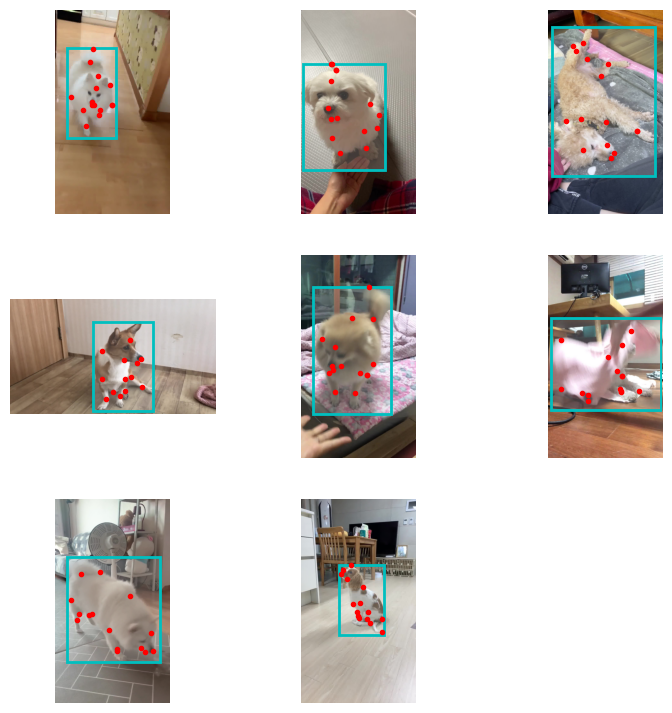

In [28]:
visualize(
    num_image=BATCH_SIZE,
    fig_size=9,
    images=train_img['image'],
    bbox=list(train_img['bbox']),
    keypoints=list(train_img['keypoints']),
)

## **Pose Estimation: Using Keypoint R-CNN**
    - Backbone: ResNet34; FPN extracted
    - Input: ...
    - Output: ...

### Download model

In [13]:
import torchvision.models.detection.keypoint_rcnn as krcnn
from torchvision.models.resnet import ResNet18_Weights, resnet18
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor

In [14]:
backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
backbone = _resnet_fpn_extractor(backbone, 3) #trainable layer: 3

model_PE = krcnn.KeypointRCNN(
    backbone=backbone,
    num_classes=2,
    min_size=SIZE_MIN,
    max_size=SIZE_MAX,
    num_keypoints=15,)

### Pre-Test and Visualize

In [15]:
model_PE.to(device)

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(256,), max_size=512, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, moment

In [25]:
model_PE.eval()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(256,), max_size=512, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, moment

In [17]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"

In [37]:
p = model_PE([x.to(device) for x in val_img['image']])

In [36]:
val_img = next(iter(val_dataloader))

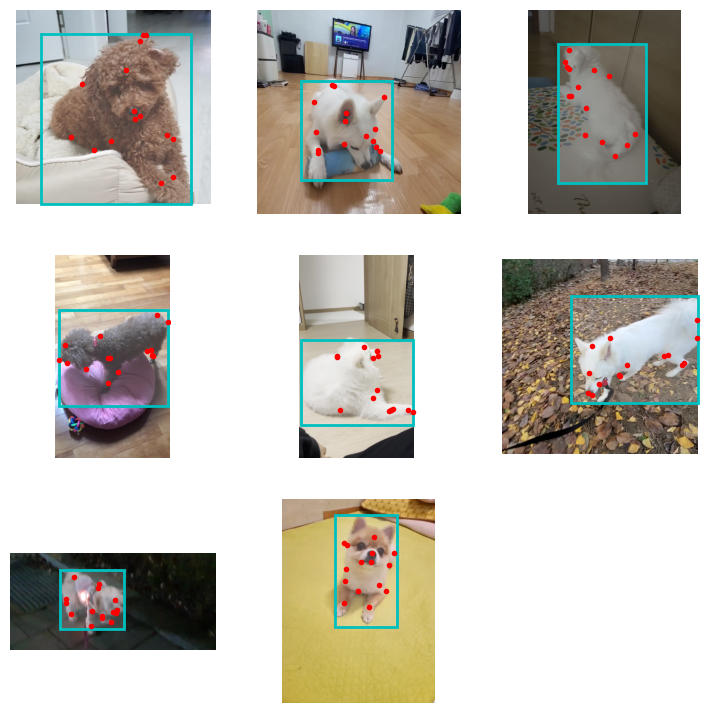

In [38]:
with torch.no_grad():
    visualize(
        num_image=BATCH_SIZE,
        fig_size=9,
        images=val_img['image'],
        bbox=[x['boxes'][0].cpu() for x in p],
        keypoints=[x['keypoints'][0].cpu() for x in p],
    )

In [ ]:
#model_PE.load_state_dict(torch.load('state/test_ep1'))

### Training

In [20]:
model_PE.train()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(256,), max_size=512, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, moment

In [21]:
optimizer = opt.Adam(model_PE.parameters(), lr=LEARNING_RATE)

In [22]:
loss_train = []

for e in range(EPOCH):
    for data in tqdm(sub1_dataloader):
        optimizer.zero_grad()
        
        image = [x.to(device) for x in data['image']]
        target = [{
            'boxes': data['bbox'][i].unsqueeze(0).to(device),
            'labels': torch.ones(1, dtype=torch.long, device=device),
            'keypoints': data['keypoints'][i].unsqueeze(0).to(device),
        } for i in range(len(data['image']))]
        
        loss = sum(model_PE(image, target).values())
        loss.backward()
        optimizer.step()
        loss_train.append(loss)

100%|████████████████████████████████████████████████████████████████████████████████| 662/662 [05:37<00:00,  1.96it/s]


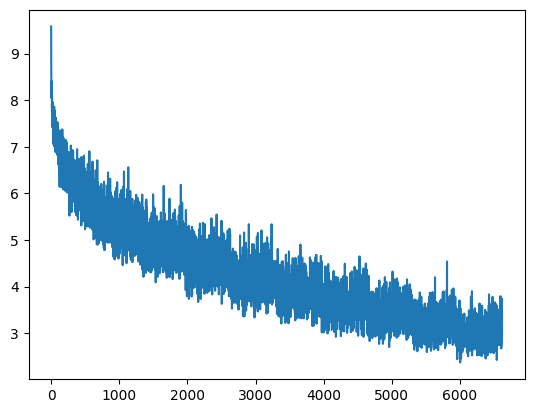

In [23]:
with torch.no_grad():
    plt.plot([x.cpu() for x in loss_train])

In [24]:
torch.save(model_PE.state_dict(), 'state/test_ep1')

In [29]:
import pickle

In [34]:
with torch.no_grad():
    with open('state/loss_ep1.pkl','wb') as f:
        pickle.dump([x.cpu() for x in loss_train], f)

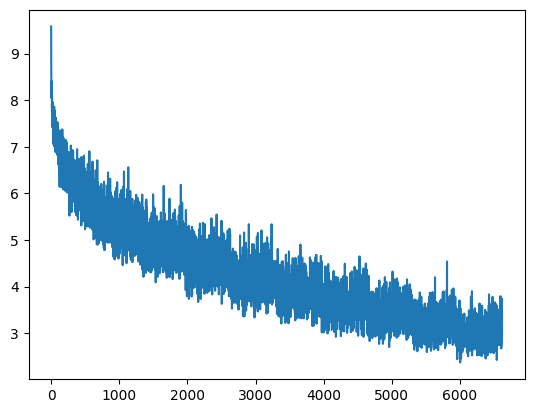

In [35]:
with open('state/loss_ep1.pkl','rb') as f:
    new = pickle.load(f)
plt.plot(new)

# Memo